# **Предсказание рейтинга приложения в Google Store**
### **Дата собрания данных**
Для извлечения данных с каждой страницы автор датасета использовал данную технологию: https://github.com/gauthamp10/Google_Play_App_Info для извлечения данных с каждой страницы. Данные были собраны в апреле 2019 года.

### **Описание признаков**
- `Rating`   - Целевой признак - рейтинг от 1 до 5
- `App Name` - Название приложения
- `Category` - Категория
- `Reviews`  - Количество отзывов
- `Installs` - Количество установок
- `Size`     - Размер приложения (в кб и мб)
- `Price`    - Стоимость
- `Content Rating` - Контент рейтинг
- `Last Updated`   - Последнее обновление (дата)
- `Minimum Version` - Минимальная версия андроид
- `Latest Version`  - Последняя версия приложения


Библиотеки

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from scipy.sparse import hstack, vstack
from sklearn.model_selection import train_test_split,\
                                    GridSearchCV,\
                                    KFold,\
                                    validation_curve,\
                                    learning_curve
                                    
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
df_source = pd.read_csv('/content/drive/My Drive/ml_python/Google-Playstore-Full.csv')

In [ ]:
df = df_source.copy()

# 1. Анализ и предобработка данных

In [ ]:
df.head()

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,DoorDash - Food Delivery,FOOD_AND_DRINK,4.548561573,305034,"5,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
1,TripAdvisor Hotels Flights Restaurants Attract...,TRAVEL_AND_LOCAL,4.400671482,1.20792e+06,"100,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
2,Peapod,SHOPPING,3.656329393,1967,"100,000+",1.4M,0,Everyone,"September 20, 2018",5.0 and up,2.2.0,NaN,NaN,NaN,NaN
3,foodpanda - Local Food Delivery,FOOD_AND_DRINK,4.107232571,389154,"10,000,000+",16M,0,Everyone,"March 22, 2019",4.2 and up,4.18.2,NaN,NaN,NaN,NaN
4,My CookBook Pro (Ad Free),FOOD_AND_DRINK,4.647752285,2291,"10,000+",Varies with device,$5.99,Everyone,"April 1, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN


In [ ]:
df.describe()

,Unnamed: 14
count,1.0
mean,9.1
std,NaN
min,9.1
25%,9.1
50%,9.1
75%,9.1
max,9.1


In [ ]:
#выбрасываем ненужные колонки с пустыми значениями
df.drop([ 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267052 entries, 0 to 267051
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   App Name         267051 non-null  object
 1   Category         267051 non-null  object
 2   Rating           267052 non-null  object
 3   Reviews          267051 non-null  object
 4   Installs         267052 non-null  object
 5   Size             267052 non-null  object
 6   Price            267052 non-null  object
 7   Content Rating   267052 non-null  object
 8   Last Updated     267052 non-null  object
 9   Minimum Version  267051 non-null  object
 10  Latest Version   267049 non-null  object
dtypes: object(11)
memory usage: 22.4+ MB


In [ ]:
# возьмем только те данные, где вес определен, то есть не "зависит от устройства"
df = df[df.Size.str.contains('\d')] 
len(df)

255325

In [ ]:
# наличие цены надо заменить на 0 и 1
df.Price = df.Price.str.contains('1|2|3|4|5|6|8|9').map({
    True: 1,
    False: 0
})

In [ ]:
# исключает из данные, где рейтинг имеет строковую запись
# приводим рейтинг к числовому типу
df = df[df.Rating.str.contains("0|1|2|3|4|5|6|7|8|9", na=False)] 
len(df)

250525

In [ ]:
df.Rating = df.Rating.astype(float)

In [ ]:
# переведем все Кб в Мб
df.Size = df.Size.str.replace(',', '')
df.Size = (df.Size.replace(r'[kM]+$', '', regex=True).astype(float) / 
            df.Size.str.extract(r'[\d\.]+([kM]+)', expand=False).fillna(1).replace(['k','M'], [10**3, 1]).astype(float))

In [ ]:
# переведем все installs в int
df.Installs = df.Installs.str.replace('\+','')
df.Installs = df.Installs.str.replace(',','')
df.Installs = df.Installs.astype(int)

In [ ]:
# переведем все Reviews в int
df.Reviews = df.Reviews.astype(int)

In [ ]:
# преведем дату ко временному формату
df['Last Updated'] = df['Last Updated'].apply(pd.to_datetime)

In [ ]:
# исключим из выборки поля, где имена равно nan
df = df[~df['App Name'].isna()]

In [ ]:
# исключим колонки Minimum Version и Latest Version, тк в современном мире на них уже не обращают внимания
df.drop([ 'Minimum Version', 'Latest Version'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250524 entries, 2 to 262143
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   App Name        250524 non-null  object        
 1   Category        250524 non-null  object        
 2   Rating          250524 non-null  float64       
 3   Reviews         250524 non-null  int64         
 4   Installs        250524 non-null  int64         
 5   Size            250524 non-null  float64       
 6   Price           250524 non-null  int64         
 7   Content Rating  250524 non-null  object        
 8   Last Updated    250524 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 19.1+ MB


In [ ]:
# проверим наличие пропусков в данных
df.isnull().sum()

App Name          0
Category          0
Rating            0
Reviews           0
Installs          0
Size              0
Price             0
Content Rating    0
Last Updated      0
dtype: int64

In [ ]:
df.to_csv('/content/drive/My Drive/ml_python/clean_df.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/ml_python/clean_df.csv')

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.describe()

,Rating,Reviews,Installs,Size,Price
count,250524.000000,2.505240e+05,2.505240e+05,250524.000000,250524.000000
mean,4.272219,1.002331e+04,3.862939e+05,15.602418,0.041449
std,0.587586,2.284620e+05,6.708677e+06,18.359893,0.199327
min,1.000000,1.000000e+00,0.000000e+00,0.003100,0.000000
25%,4.022031,1.600000e+01,1.000000e+03,4.100000,0.000000
50%,4.385737,8.800000e+01,1.000000e+04,8.400000,0.000000
75%,4.653395,5.910000e+02,5.000000e+04,20.000000,0.000000
max,5.000000,4.840147e+07,1.000000e+09,347.000000,1.000000


Видно, что потенциальные кандидаты на отнесение к выбросам находятся в колонка `Reviews` и `Installs`


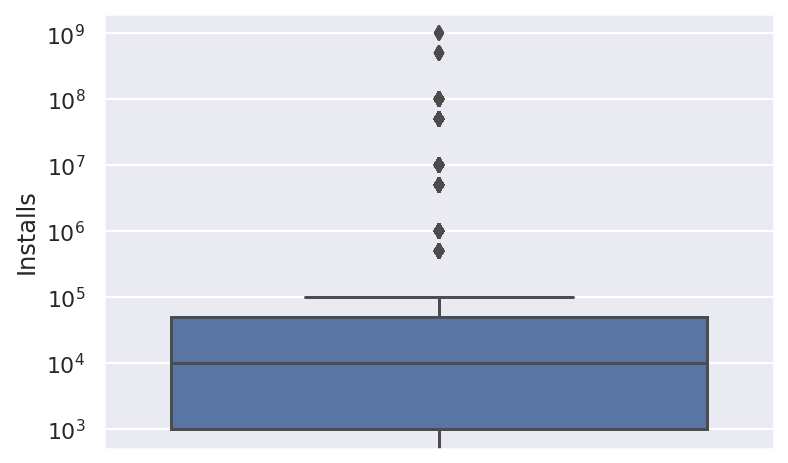

In [ ]:
sns.boxplot(df.Installs, orient='v')
plt.yscale('log')

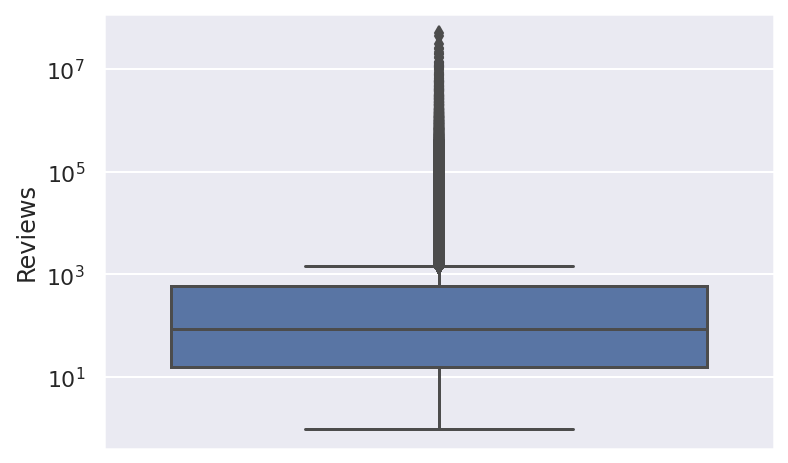

In [ ]:
sns.boxplot(df.Reviews, orient='v')
plt.yscale('log')

Объекты, которые можно считать выбросами присутствуют.

In [ ]:
df.sort_values(by=['Reviews'], ascending=False)[:5]

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated
628,Clash of Clans,GAME_STRATEGY,4.606215,48401470,500000000,103.0,0,Everyone 10+,2019-04-02
7064,"Clean Master - Antivirus, Applock & Cleaner",TOOLS,4.657038,44171776,1000000000,20.0,0,Everyone,2019-04-01
539,Subway Surfers,GAME_ARCADE,4.498131,29834812,1000000000,85.0,0,Everyone 10+,2019-03-07
1542,Clash Royale,GAME_STRATEGY,4.545474,25449254,100000000,81.0,0,Everyone 10+,2019-02-13
680,Candy Crush Saga,GAME_CASUAL,4.450046,24657922,500000000,85.0,0,Everyone,2019-03-22


[Clash of Clans](https://play.google.com/store/apps/details?id=com.supercell.clashofclans&hl=ru). Данные собирались в 2019 году, на тот момент датасет утверждает, что у приложения было 48кк. На момент просмотра 17.06.2020 отзывов 55кк, в принципе, я полагаю, что можно верить.

---
Clean Master - Antivirus, Applock & Cleaner - не смог найти приложения с точно таким же названием. Но вспоминая 2016-17 года, думаю каждый искал на свой телефон приложение для очистки. Так что я думаю данные правдивые.

---
[Subway Surfers](https://play.google.com/store/apps/details?id=com.kiloo.subwaysurf&hl=ru) - сейчас 33 008 471, в датасете 29 834 812. С течение времени.

---
[Clash Royale](https://play.google.com/store/apps/details?id=com.supercell.clashroyale&hl=ru) - 28 815 352, в датасете 25 449 254. Можно также заметить, что рейтинг игры упал, до 4.3, так что можно предположить, что люди удаляли комментарии после удаления игры.

---
[Candy Crush Saga](https://play.google.com/store/apps/details?id=com.king.candycrushsaga&hl=ru) 28 837 494, в датасете 24 657 922. Рейтинг игры тоде возрос, все нормально.

Text(0.5, 1.0, 'Гистограмма целевого признака')

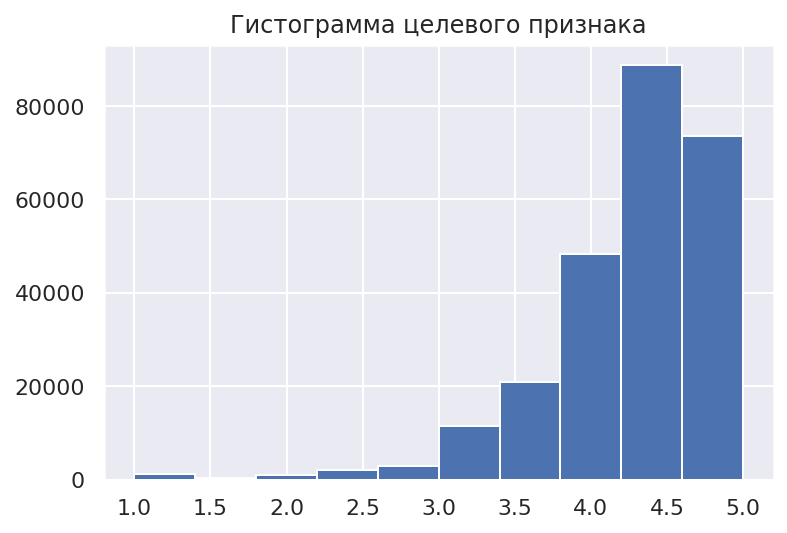

In [ ]:
df['Rating'].hist()
plt.title("Гистограмма целевого признака")

Целью корреляционного анализа является отбор признаков для дальнейшего построения модели регрессии.

Text(0.5, 1.0, 'Корреляция данных друг с другом')

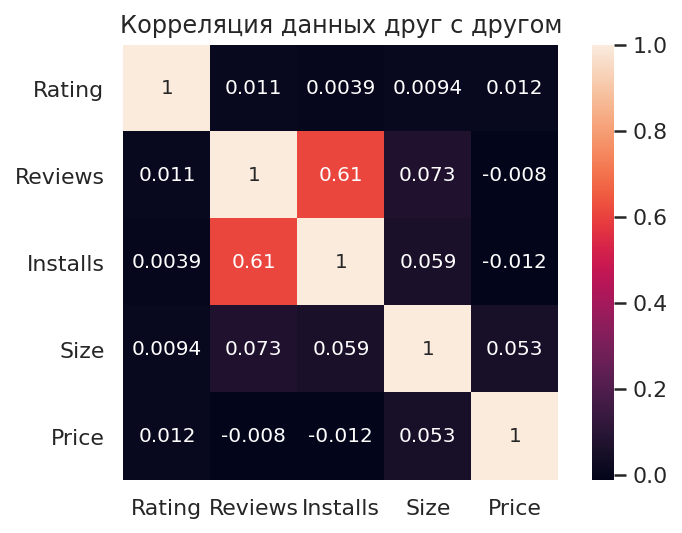

In [ ]:
sns.heatmap(df.corr(),
            square=True,
            annot=True)
plt.title("Корреляция данных друг с другом")

Выявилась очевидная сильная корреляция между количеством скачиваний и количеством отзывов.

---
Но корреляции с целевым признаком почти отсутствуют.

Text(0.5, 1.0, 'Количество приложений по контент рейтингу')

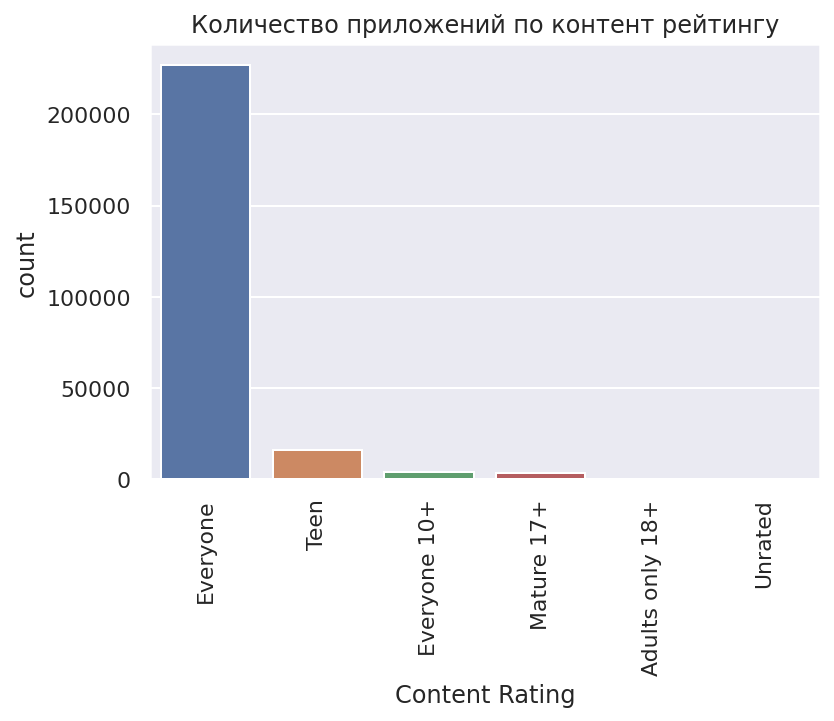

In [ ]:
sns.countplot(df['Content Rating'])
plt.xticks(rotation=90)
plt.title('Количество приложений по контент рейтингу')

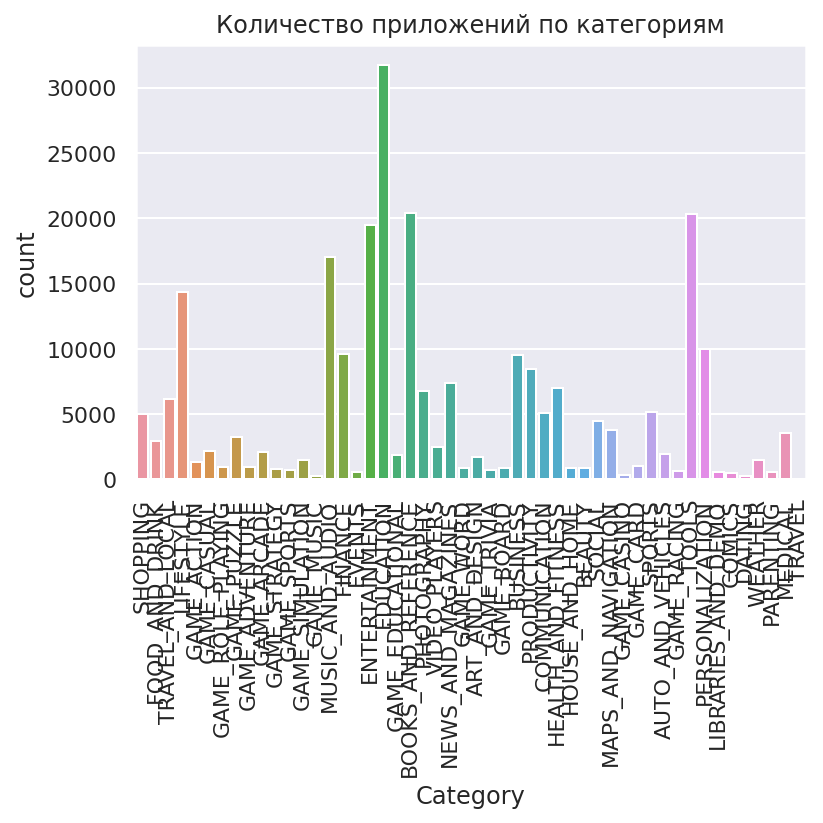

In [ ]:
sns.countplot(df.Category)
plt.xticks(rotation=90)
plt.title('Количество приложений по категориям')
plt.show()

Возможно, выборку стоит разделить на игры и прочие прилоежния.

In [ ]:
games = df[df.Category.str.contains('GAME')]
other = df[~df.Category.str.contains('GAME')]

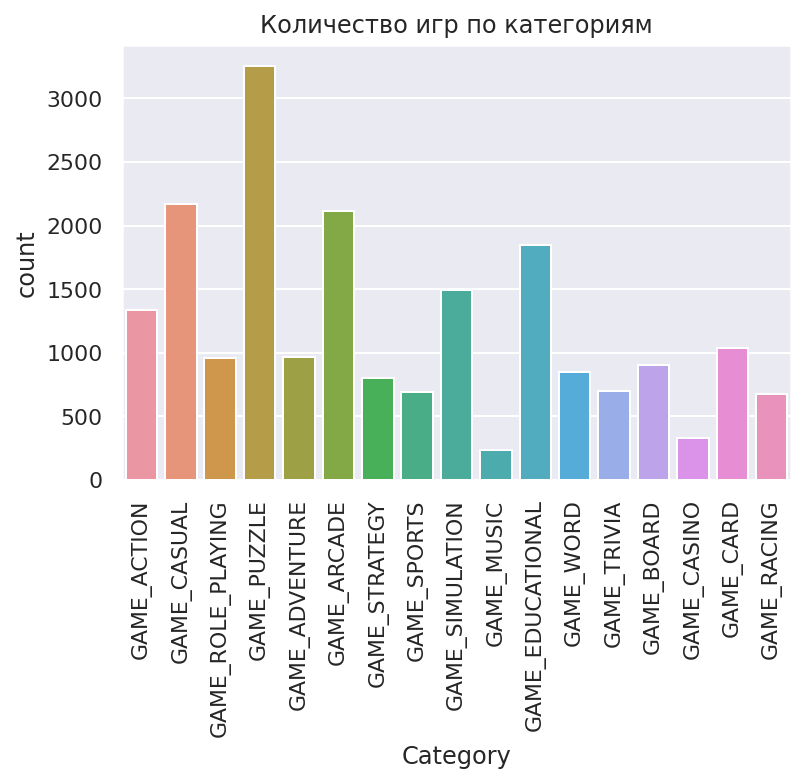

In [ ]:
sns.countplot(games.Category)
plt.xticks(rotation=90)
plt.title('Количество игр по категориям')
plt.show()

График стал нагляднее. Заметно, что игры составляют меньшую часть Google Store, относительно прочих приложений. А также можно заметить, что в Google Store много приложений по категории Пазл.

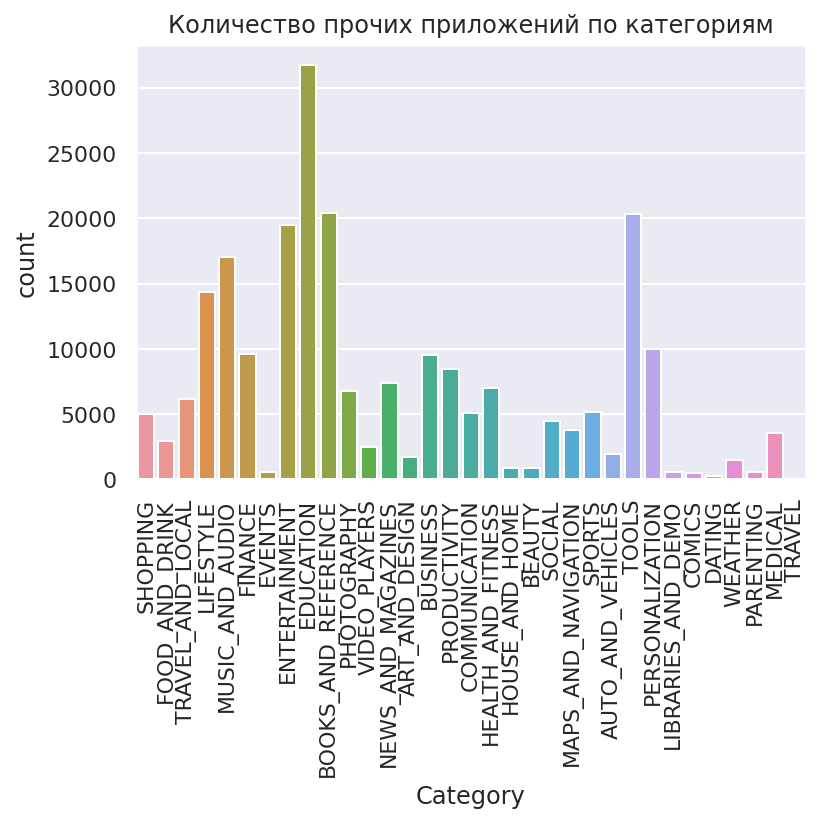

In [ ]:
sns.countplot(other.Category)
plt.xticks(rotation=90)
plt.title('Количество прочих приложений по категориям')
plt.show()

Большую часть Google Store занимаются приложения по категорям Образование, Инструменты и Читалками.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

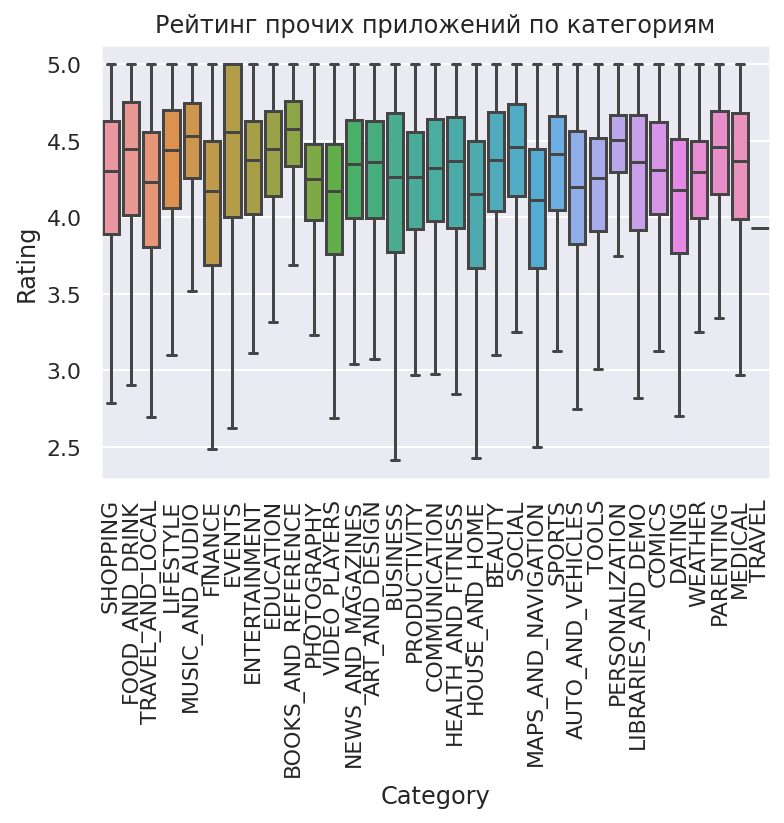

In [ ]:
sns.boxplot('Category', 'Rating', showfliers=False, data=other)
plt.title('Рейтинг прочих приложений по категориям')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

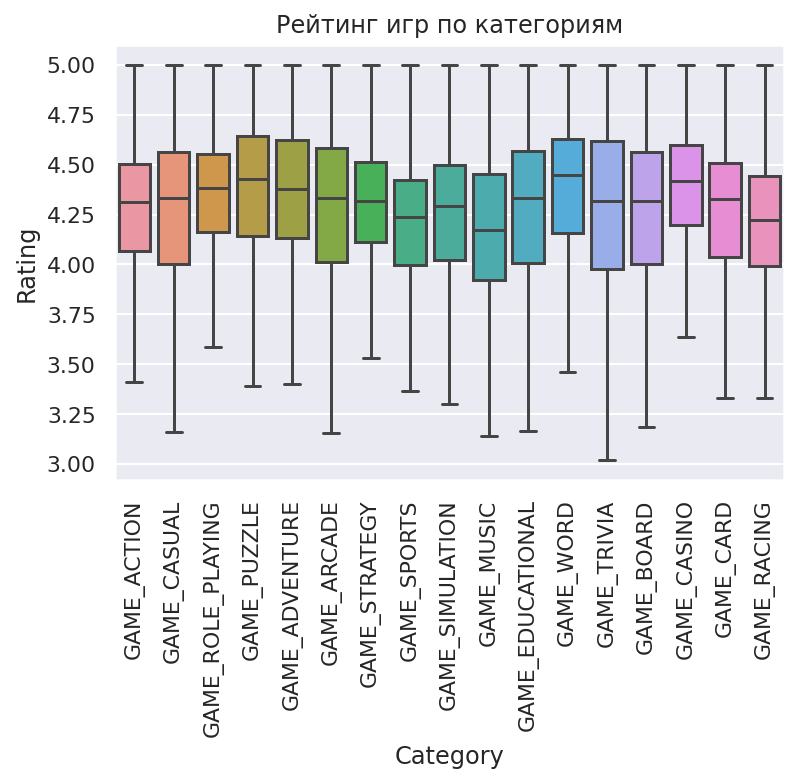

In [ ]:
sns.boxplot('Category', 'Rating', showfliers=False, data=games)
plt.title('Рейтинг игр по категориям')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

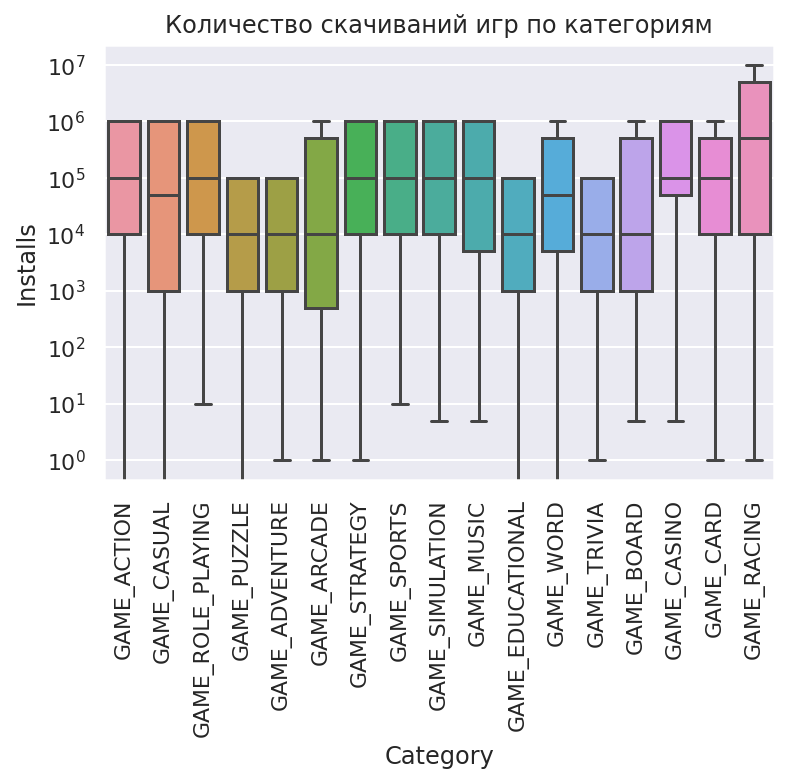

In [ ]:
sns.boxplot('Category', 'Installs', showfliers=False, data=games)
plt.title('Количество скачиваний игр по категориям')
plt.yscale('log')
plt.xticks(rotation=90)


По данномк графику, можно заметить, что чаще всего скачивают racing (гонки). Но в целом среднее по всем играм одинаковое. Делаю вывод, что у мобильных игроков в целом нет особых предпочтений по поводу жанра игры на телефон.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

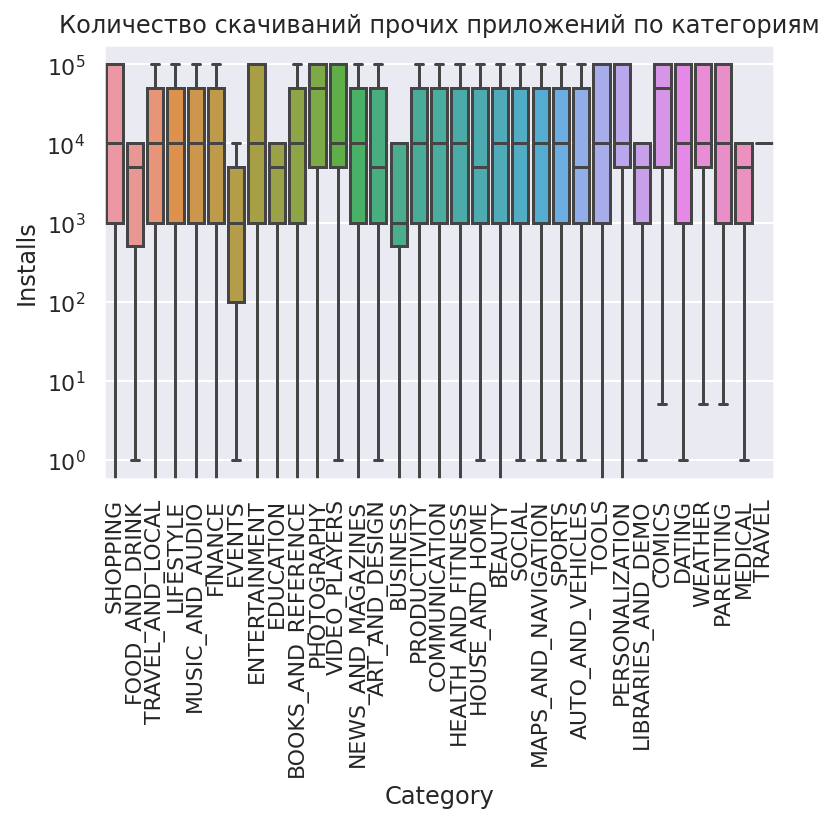

In [ ]:
sns.boxplot('Category', 'Installs', showfliers=False, data=other)
plt.title('Количество скачиваний прочих приложений по категориям')
plt.yscale('log')
plt.xticks(rotation=90)

По графику видно, что реже всех скачивают EVENTS и BUSINESS.
Чаще скачивают приложения для фотографий и комиксы.

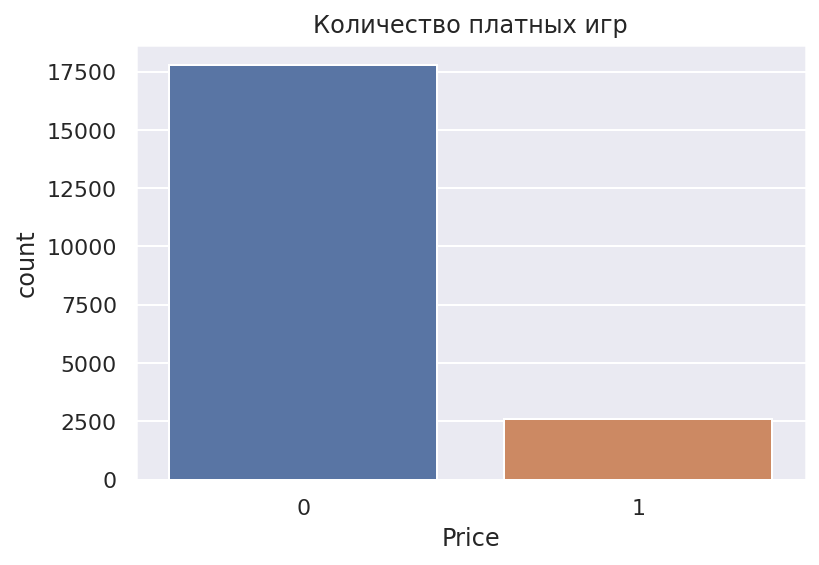

In [ ]:
sns.countplot(games.Price)
plt.title('Количество платных игр')
plt.show()

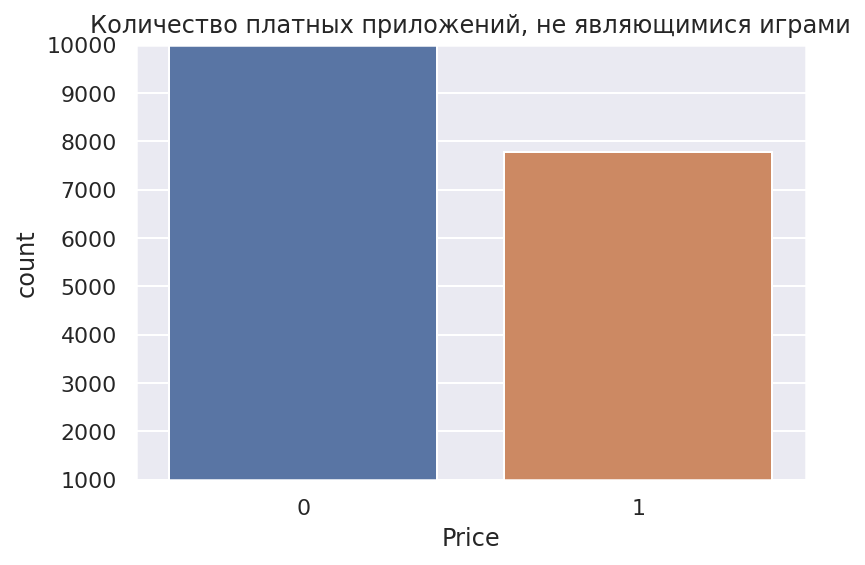

In [ ]:
sns.countplot(other.Price)
plt.title('Количество платных приложений, не являющимися играми')
plt.ylim(1000,10000)
plt.show()

In [ ]:
games.shape, other.shape

((20374, 9), (230149, 9))

На графиках заметно, что игр меньше, чем остальных приложений. Но как как они относят к категории менее мне интересной, то использовать я буду other.

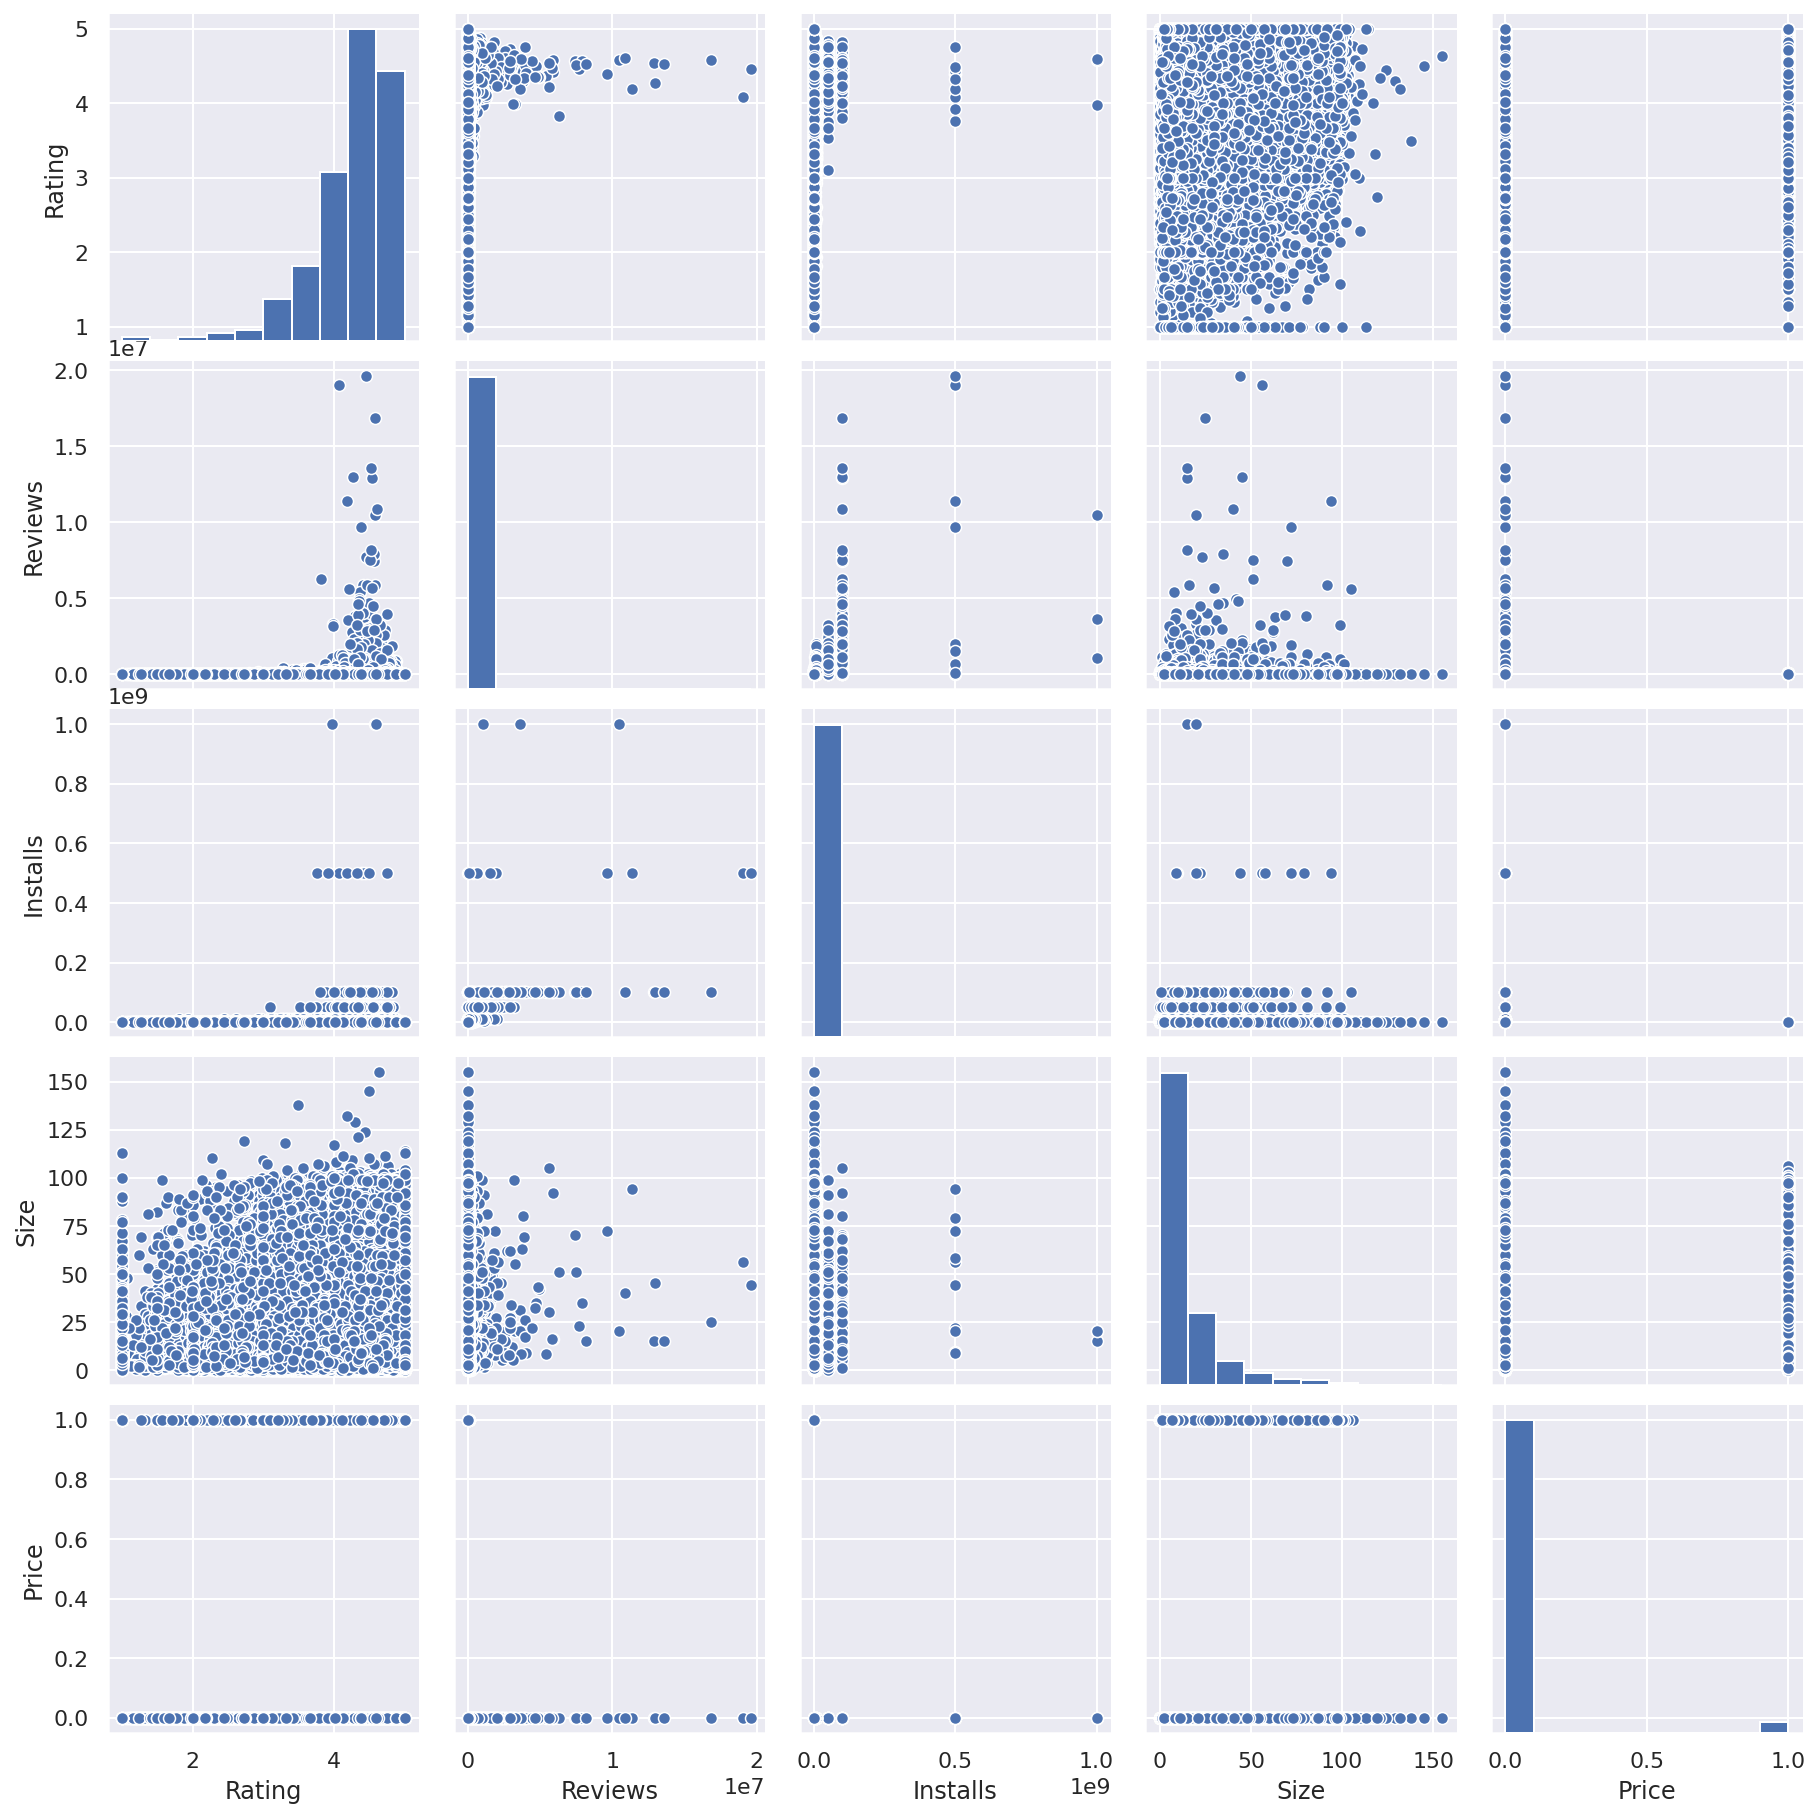

In [ ]:
sns.pairplot(other)

Text(0.5, 1.0, 'Распределение целевого признака')

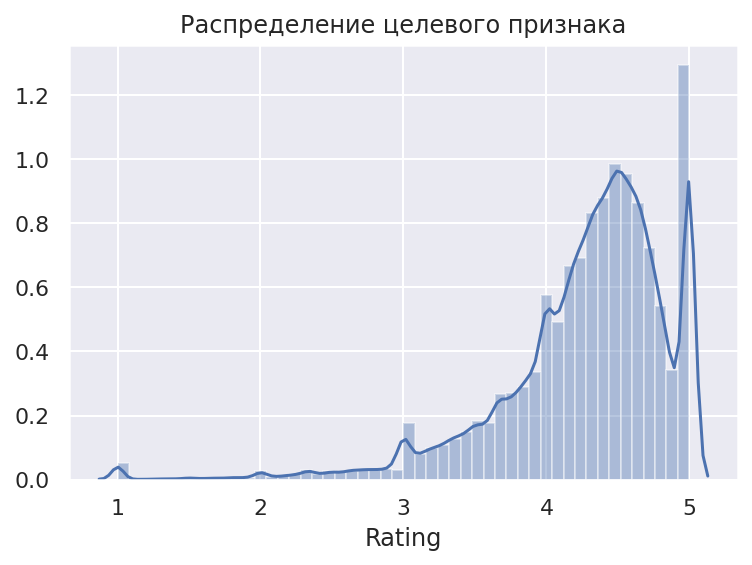

In [ ]:
sns.distplot(other.Rating)
plt.title('Распределение целевого признака')

In [ ]:
from scipy.stats import normaltest, skewtest, probplot, boxcox
from scipy.special import inv_boxcox

In [ ]:
# проведем тест на скошенность распределения 
skewtest(other.Rating)

SkewtestResult(statistic=-240.05056869140265, pvalue=0.0)

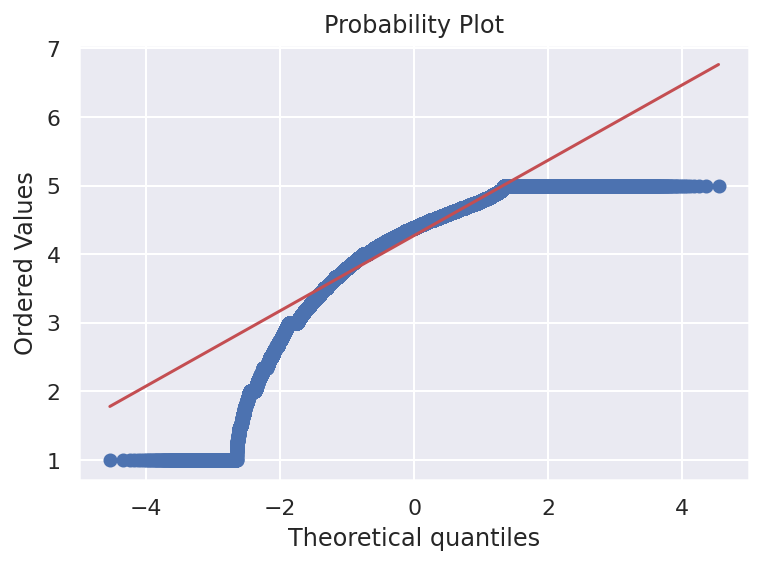

In [ ]:
probplot(df.Rating, dist="norm", plot=plt);

Видно, что распределение не является нормальным. Из курса теории известно, что  для решения задачи регрессии распределение необходимо привести к нормальному.

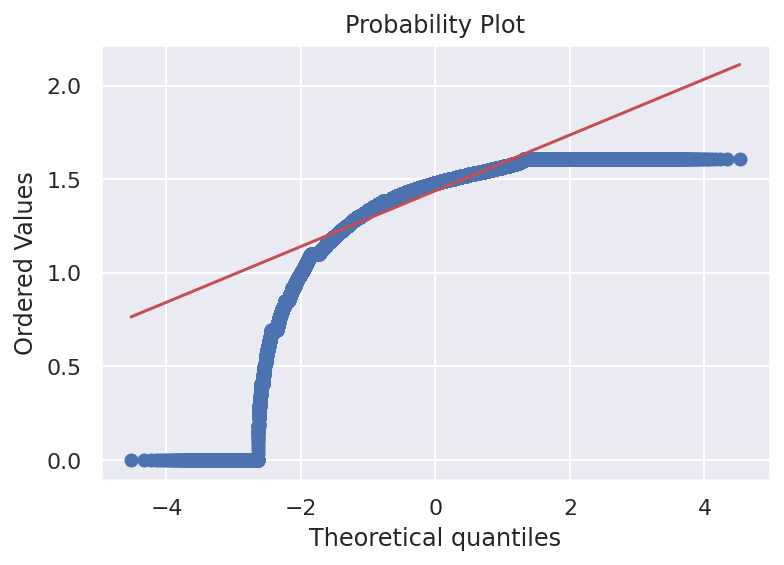

In [ ]:
probplot(np.log(other.Rating), dist="norm", plot=plt)

Все стало хуже...

((array([-4.52556525, -4.33432392, -4.23056172, ...,  4.23056172,
          4.33432392,  4.52556525]),
  array([  0.        ,   0.        ,   0.        , ..., 132.19610235,
         132.19610235, 132.19610235])),
 (31.650450740194294, 78.50258535378357, 0.989504639438038))

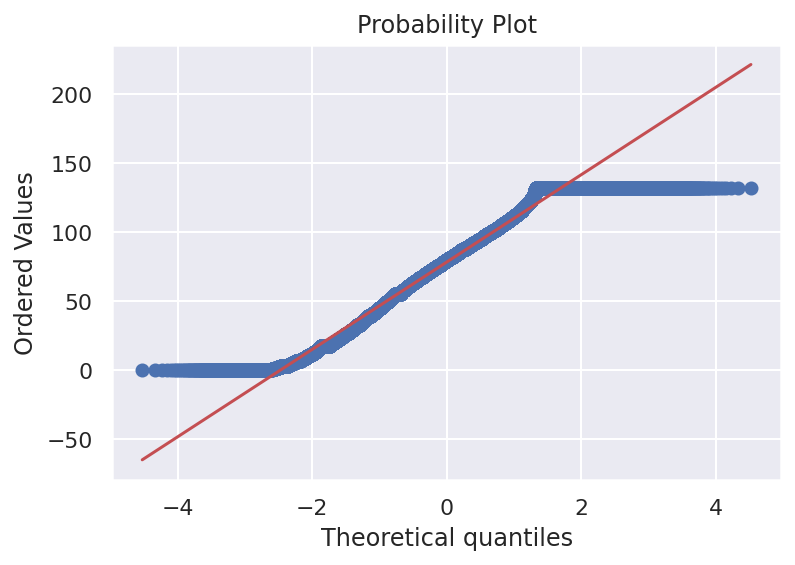

In [ ]:
# используем преобразование Бокса-Кокса для приведения распределения к нормальному виду
other['bc_rating'], bc_lmbda = boxcox(other.Rating)
probplot(other['bc_rating'], dist="norm", plot=plt)

In [ ]:
alpha = 1e-3

x2, p = normaltest(other['bc_rating'])
print("p = {:.3f}".format(p))

if p < alpha:  # true - маловероятно, чтобы данные поступали из нормального распределения
    print("Нулевая гипотеза может быть отклонена - не норм")
else:
    print("Нулевая гипотеза НЕ может быть отклонена - норм")

p = 0.000
Нулевая гипотеза может быть отклонена - не норм


normaltest возвращает 2-кортеж статистики хи-квадрат и связанное с ним значение p. Учитывая нулевую гипотезу о том, что x поступает из нормального распределения, p-значение представляет вероятность того, что статистика хи-квадрата будет видна (или больше).

Если p очень мал, это означает, что маловероятно, чтобы данные поступали из нормального распределения.
Но я приблизился к нормальной.

In [ ]:
bc_lmbda

3.878114268746552

In [ ]:
bc_lmbda1 = 3.878114268746552

In [ ]:
other.to_csv('/content/drive/My Drive/ml_python/clean_df_other.csv')

In [ ]:
other = pd.read_csv('/content/drive/My Drive/ml_python/clean_df_other.csv')
other.drop('Unnamed: 0', axis=1, inplace=True)

Стало лучше.
Пронаблюдаем, за равномерностью распределения после преобразования

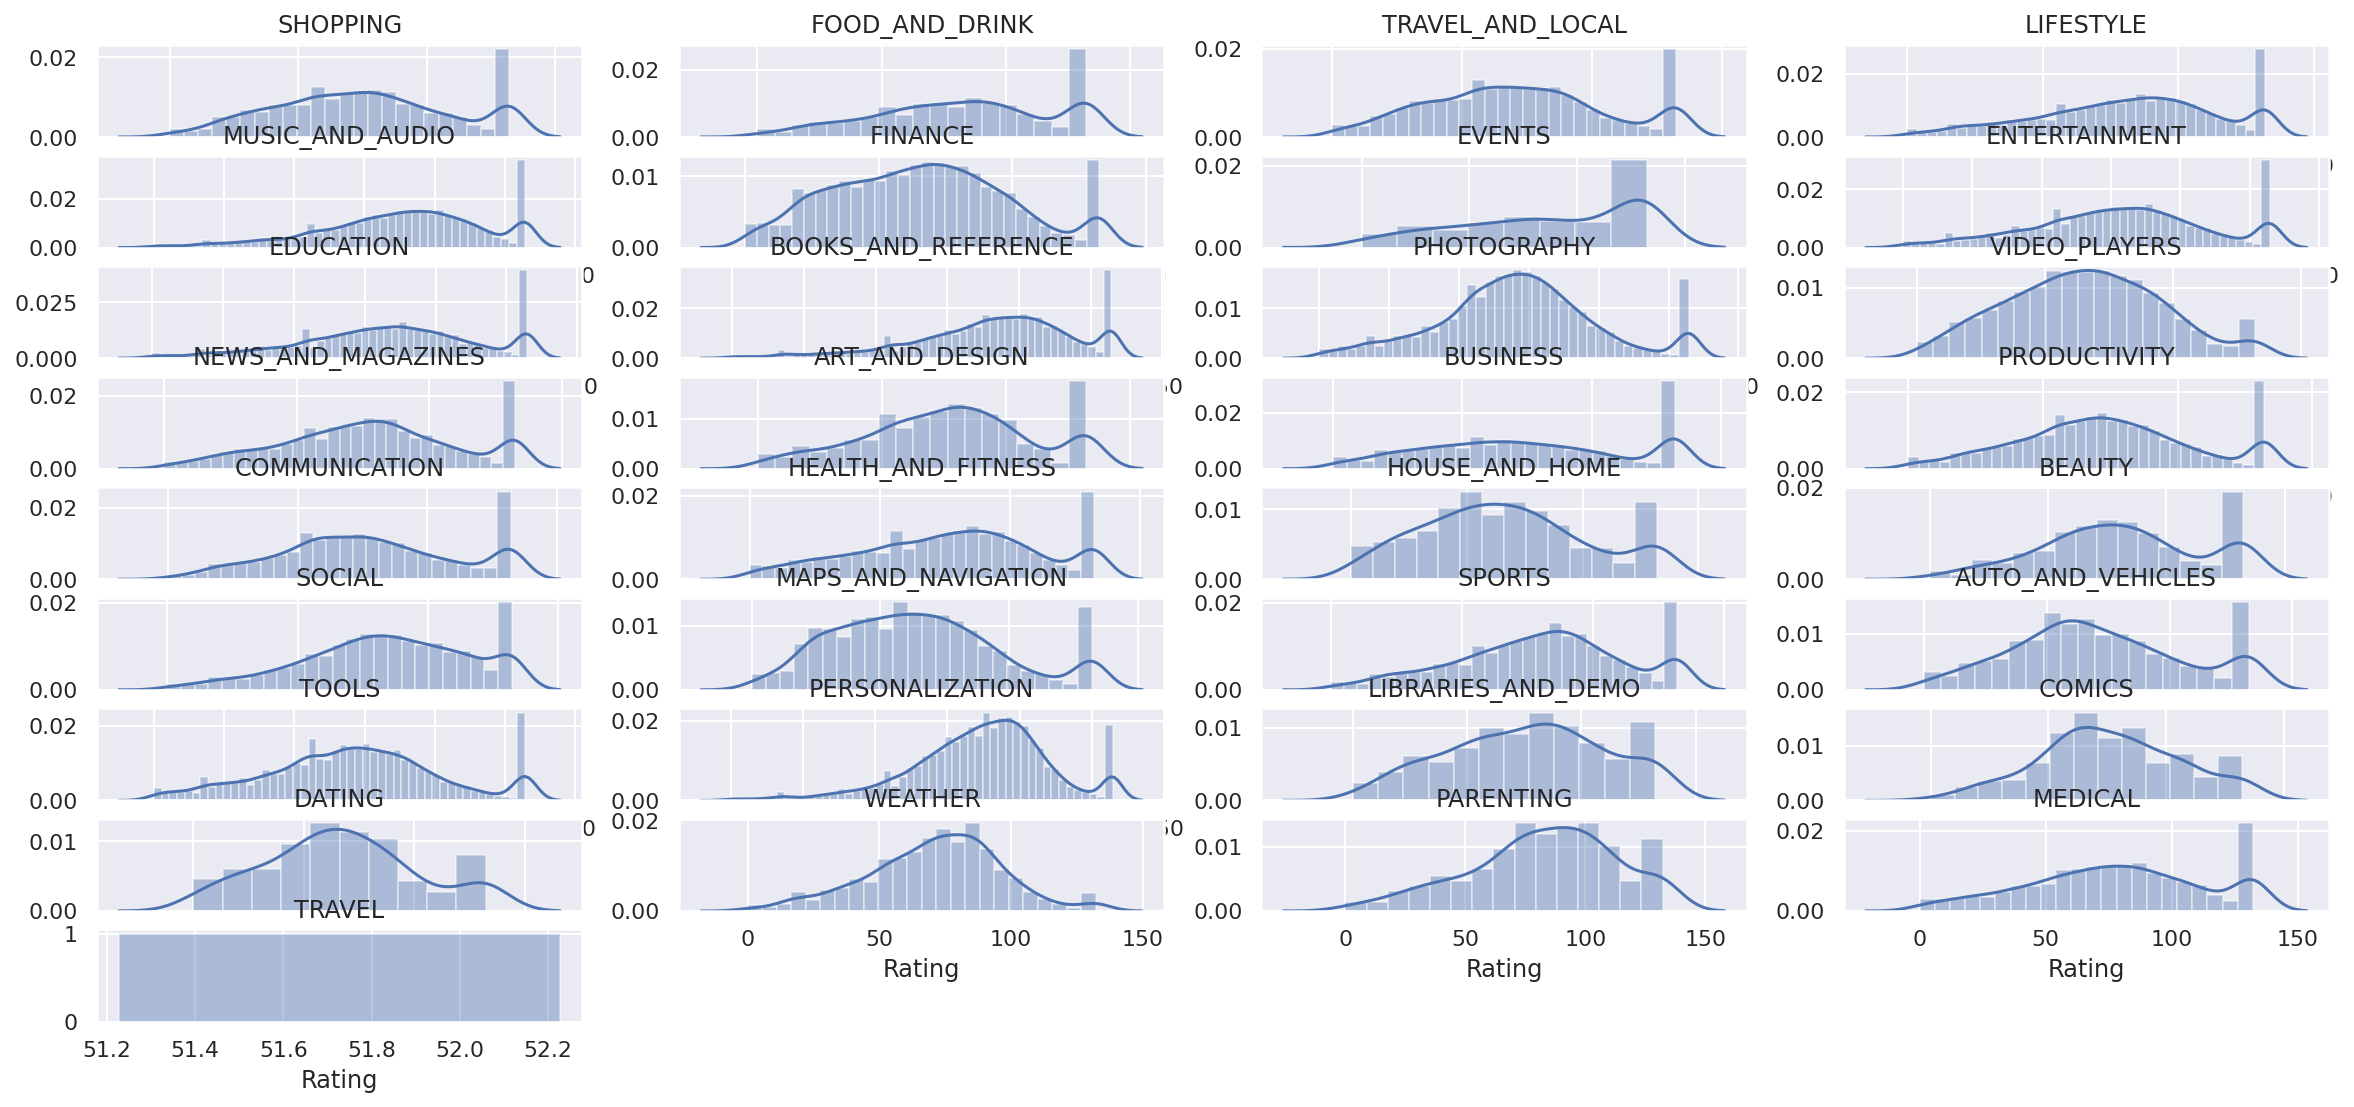

In [ ]:
plt.figure(figsize=(20, 10))
for idx, cat in enumerate(other.Category.unique()):
    plt.subplot(10, 4, idx + 1)
    plt.title(cat)
    sns.distplot(other[other['Category'] == cat]['bc_rating'])
    plt.xlabel('Rating')

Смотрим распределение по категориям.

# Преобразования данных

###Создадим новые признаки

In [ ]:
# конъюнкция двух признаков Category + Size
other['Category_Size'] = other.Category.astype(str) + ' ' + other.Size.astype(str)
# закодируем каждую категорию числом входящих в неё объектов
other['Category_Size'] = other['Category_Size'].map(other.groupby('Category_Size').size())

In [ ]:
# кол-во приложений со стоимостью по категориям
other['Prcnt_Price_Category'] = other.Category.astype(str) + ' ' + other.Price.astype(str)
# закодируем каждую категорию числом входящих в неё объектов
other['Prcnt_Price_Category'] = other['Prcnt_Price_Category'].map(other.groupby('Prcnt_Price_Category').size())

In [ ]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230150 entries, 0 to 230149
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   App Name              230150 non-null  object        
 1   Category              230150 non-null  object        
 2   Rating                230150 non-null  float64       
 3   Reviews               230150 non-null  int64         
 4   Installs              230150 non-null  int64         
 5   Size                  230150 non-null  float64       
 6   Price                 230150 non-null  int64         
 7   Content Rating        230150 non-null  object        
 8   Last Updated          230150 non-null  datetime64[ns]
 9   bc_rating             230150 non-null  float64       
 10  Category_Size         230150 non-null  int64         
 11  Prcnt_Price_Category  230150 non-null  int64         
 12  year_month            230150 non-null  int64         
 13 

In [ ]:
other['Last Updated'] = other['Last Updated'].apply(pd.to_datetime)

In [ ]:
other['year_month'] = other['Last Updated'].apply(lambda t: 100 * t.year + t.month)

Text(0.5, 1.0, 'Распределение по дням недели(1-ПН, 7-ВС)')

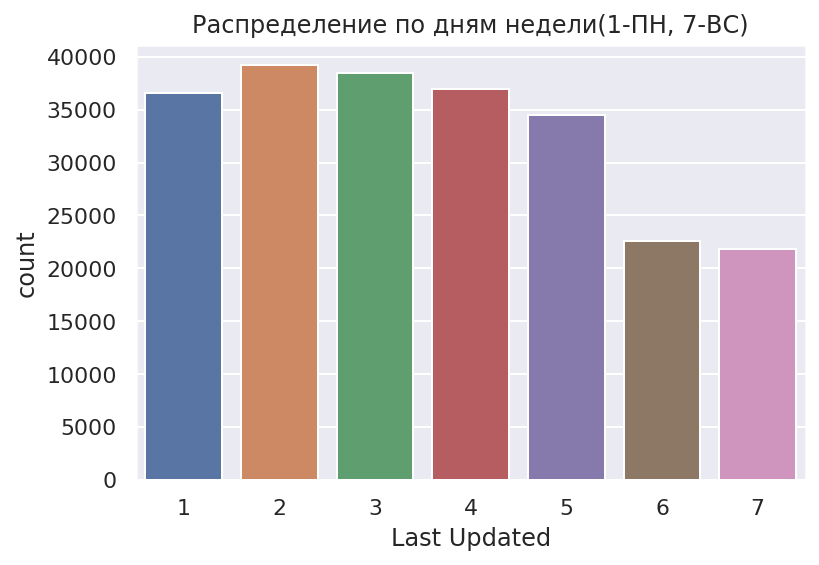

In [ ]:
sns.countplot(other['Last Updated'].apply(lambda t: t.isoweekday()))
plt.title("Распределение обновлений по дням недели(1-ПН, 7-ВС)")

Чаще всего обновления загружают во ВТОРНИК.

In [ ]:
other['Week'] = other['Last Updated'].apply(lambda t: str(t.isoweekday()))

In [ ]:
other.to_csv('/content/drive/My Drive/ml_python/feat_df_other.csv')

In [ ]:
other = pd.read_csv('/content/drive/My Drive/ml_python/feat_df_other.csv')

In [ ]:
other.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
other['Last Updated'] = other['Last Updated'].apply(pd.to_datetime)

In [ ]:
other['Week'] = other['Week'].apply(lambda t: str(t))

In [ ]:
other.info()
#при новой выгрузке надо привести Last Updated к временному формату
#week к строке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230150 entries, 0 to 230149
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   App Name              230150 non-null  object 
 1   Category              230150 non-null  object 
 2   Rating                230150 non-null  float64
 3   Reviews               230150 non-null  int64  
 4   Installs              230150 non-null  int64  
 5   Size                  230150 non-null  float64
 6   Price                 230150 non-null  int64  
 7   Content Rating        230150 non-null  object 
 8   Last Updated          230150 non-null  object 
 9   bc_rating             230150 non-null  float64
 10  Category_Size         230150 non-null  int64  
 11  Prcnt_Price_Category  230150 non-null  int64  
 12  year_month            230150 non-null  int64  
 13  Week                  230150 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 24.

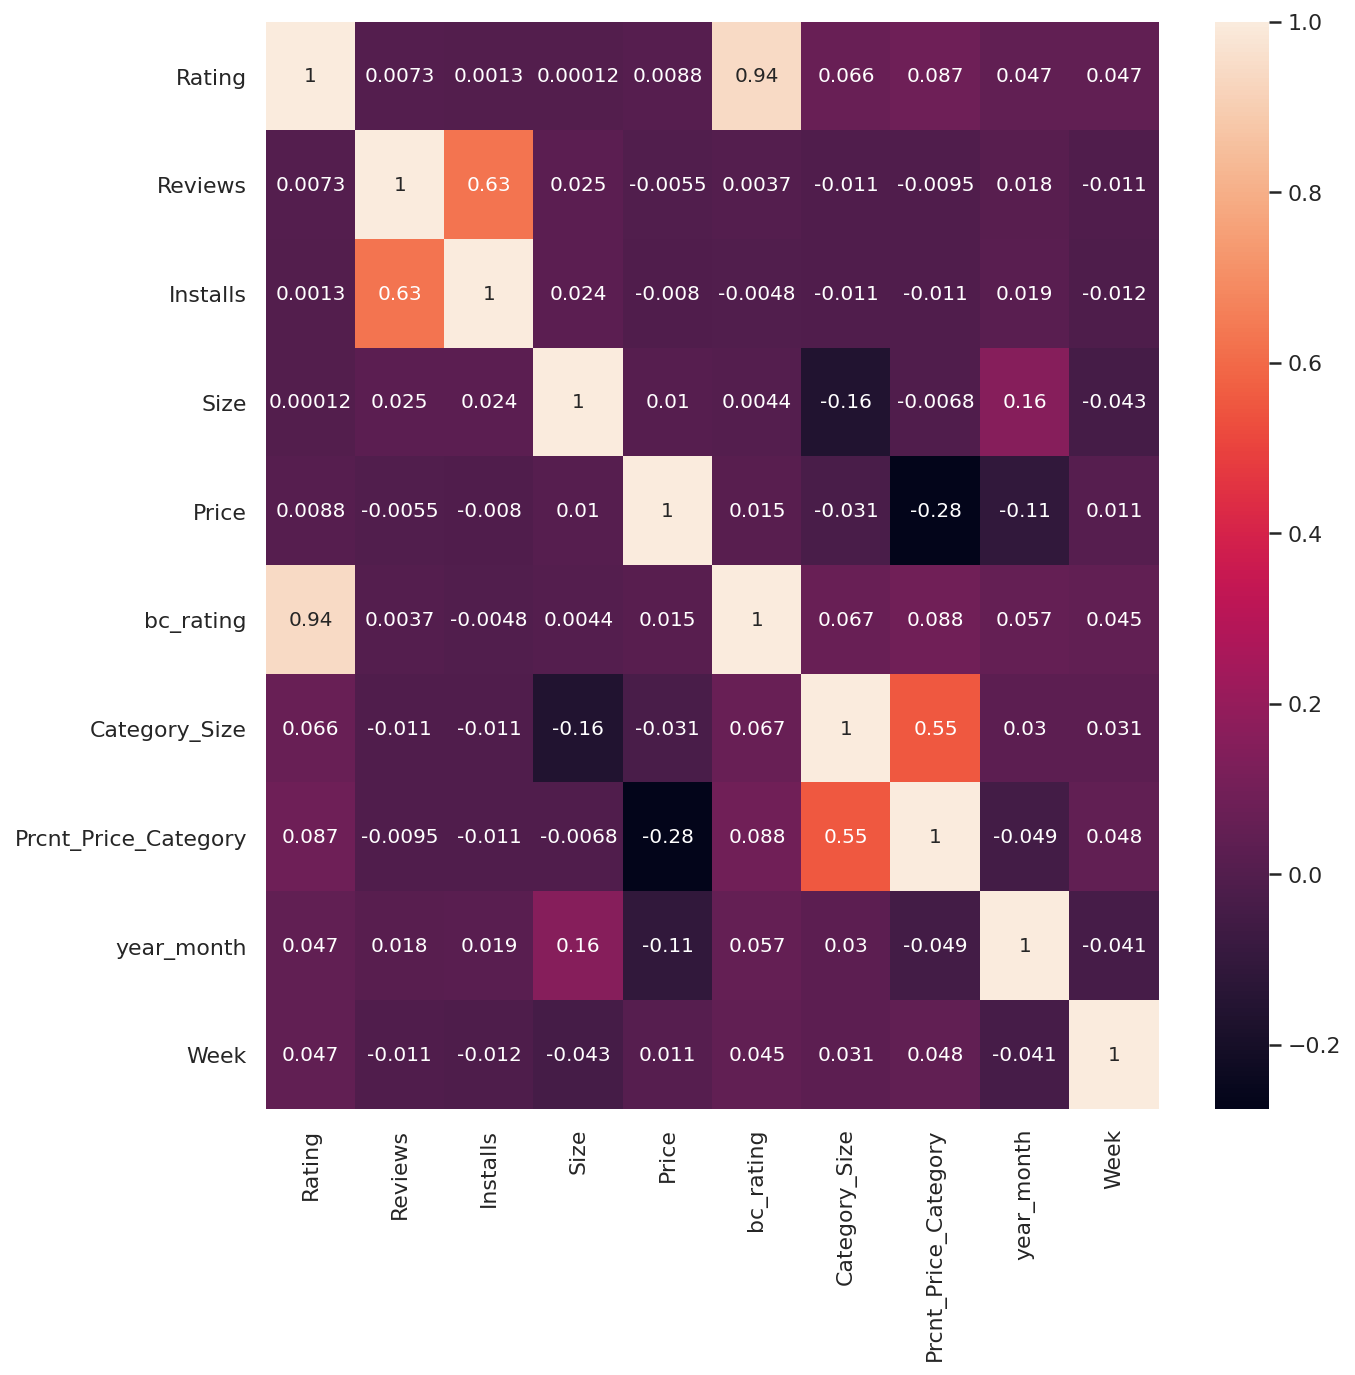

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(other.corr(),
            annot=True)

Получили еще один коррелирующий признак - процент начилия цен по категории и категория+размер приложения

### Маштабирование категориальных и количественных признаков

In [ ]:
cat_columns = [c for c in other.columns if other[c].dtype.name == 'object']
num_columns = [c for c in other.columns if other[c].dtype.name != 'object']

In [ ]:
num_columns.remove('Last Updated')

Используем MinMaxScaler, чтобы закодировать количественные признаки

In [ ]:
num_df = pd.DataFrame()
for c in num_columns:
  num_df[c] = other[c]
  
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
num_scaled = min_max_scaler.fit_transform(num_df)
num_df_scaled = pd.DataFrame(num_scaled, columns=num_columns)
num_df_scaled.head()

,Rating,Reviews,Installs,Size,Price,bc_rating,Category_Size,Prcnt_Price_Category,year_month
0,0.664082,0.000045,0.00010,0.009012,0.0,0.295706,0.015521,0.163076,0.905
1,0.776808,0.008810,0.01000,0.103208,0.0,0.465327,0.072062,0.096316,0.999
2,0.706331,0.000058,0.00010,0.148370,0.0,0.352711,0.044346,0.096316,0.999
3,0.702941,0.000002,0.00001,0.026432,0.0,0.347861,0.056541,0.196637,0.998
4,0.553382,0.000017,0.00010,0.251598,0.0,0.178474,0.057650,0.460134,0.999


In [ ]:
cat_columns

['App Name', 'Category', 'Content Rating', 'Week']

Так как регрессионная модель не может работать с категориальными данными, их также нужно закодировать при помощи OneHotEncoder или pandas.get_dummies.

In [ ]:
cat_columns.remove('App Name')
cat_columns

['Category', 'Content Rating', 'Week']

In [ ]:
cat_df = pd.DataFrame()
for c in cat_columns:
  cat_df[c] = other[c]
cat_df = pd.get_dummies(cat_df, columns=cat_columns)
concat_df = pd.concat([num_df_scaled, cat_df], axis=1)
concat_df.head()

,Rating,Reviews,Installs,Size,Price,bc_rating,Category_Size,Prcnt_Price_Category,year_month,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FINANCE,Category_FOOD_AND_DRINK,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_MUSIC_AND_AUDIO,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Week_1,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7
0,0.664082,0.000045,0.00010,0.009012,0.0,0.295706,0.015521,0.163076,0.905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0.776808,0.008810,0.01000,0.103208,0.0,0.465327,0.072062,0.096316,0.999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.706331,0.000058,0.00010,0.148370,0.0,0.352711,0.044346,0.096316,0.999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0.702941,0.000002,0.00001,0.026432,0.0,0.347861,0.056541,0.196637,0.998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0.553382,0.000017,0.00010,0.251598,0.0,0.178474,0.057650,0.460134,0.999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


# Создание выборок

In [ ]:
y = concat_df.bc_rating
X = concat_df.drop(['bc_rating', 'Rating'], axis=1)

Получим векторы названий приложений

In [ ]:
X['App Name'] = other['App Name']

In [ ]:
X.head()

,Reviews,Installs,Size,Price,Category_Size,Prcnt_Price_Category,year_month,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FINANCE,Category_FOOD_AND_DRINK,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_MUSIC_AND_AUDIO,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Week_1,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7,App Name
0,0.000045,0.00010,0.009012,0.0,0.015521,0.163076,0.905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,Peapod
1,0.008810,0.01000,0.103208,0.0,0.072062,0.096316,0.999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,foodpanda - Local Food Delivery
2,0.000058,0.00010,0.148370,0.0,0.044346,0.096316,0.999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,Safeway Online Shopping
3,0.000002,0.00001,0.026432,0.0,0.056541,0.196637,0.998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,Fast Food Locator | Worldwide Fast Food Finder
4,0.000017,0.00010,0.251598,0.0,0.057650,0.460134,0.999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,FreshDirect


In [ ]:
X.shape, y.shape

((230150, 54), (230150,))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
name_vectorizer = CountVectorizer(
    ngram_range=(1,3),
    max_features=300000,
    stop_words='english')

name_vectorizer.fit(X['App Name'])

X_name_app_vectorizer = name_vectorizer.transform(X['App Name'])

Определим нижнюю и верхнюю граница диапазона значений n для различных слов n-грамм или n-грамм символов, которые будут извлечены.То есть будем брать униграммы, биграммы, триграммы.

In [ ]:
X_name_app_vectorizer

<230150x300000 sparse matrix of type '<class 'numpy.int64'>'
	with 1085637 stored elements in Compressed Sparse Row format>

При помощи hstack собираем все матрицы в одну.

In [ ]:
X_full = hstack((
    num_scaled,
    cat_df,
    X_name_app_vectorizer
))

In [ ]:
X_full.shape, y.shape

((230150, 300055), (230150,))

In [ ]:
RANDOM_STATE = 17

In [ ]:
# используем 70% записей для обучения и на 30% проверим работу
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y,
    test_size=0.3,
    random_state=RANDOM_STATE)

In [ ]:
X_train.shape, y_train.shape

((161105, 300055), (161105,))

In [ ]:
X_test.shape, y_test.shape

((69045, 300055), (69045,))

# Выбор метрики

Так как я планирую работать с линейной регрессией, то в качестве метрики думаю использовать среднее абсолютное отклонение (MAE), так как она довольно легко рассчитывается, и наглядна.
Эта метрика даст представление о том, насколько неправильными были прогнозы.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.metrics import mean_absolute_error

# Выбор модели

После того как вы подготовили данные, можно начинать обучение модели. Я использую класс LinearRegression. Так как данная модель используется для предсказания непрерывной величины, в нашем случае это будет прогноз рейтинг приложения.

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print("score: ", reg.score(X_train, y_train))
print("intercept: ", reg.intercept_)

score:  0.9999999999998401
intercept:  -1.446588775433355e-07


In [ ]:
inv_boxcox(reg.score(X_train, y_train), bc_lmbda)

1.5047722766031362

Обычная линейная регрессия с параметрами по умолчанию может ошибаться на 1,5 балла.

In [ ]:
def graf(y_pred, y_test, y_train_pred, y_train):
  plt.scatter(y_train_pred, y_train_pred - y_train, label='Train')
  plt.scatter(y_pred, y_pred - y_test, label='Test')
  plt.hlines(0, -1, 1, label='Ось отклонения')
  plt.legend(loc='best')
  plt.ylabel('Остаток')
  plt.xlabel('Предсказания')

# Кросс-валидация и настройка гиперпараметров модели

In [ ]:
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=5, random_state=RANDOM_STATE)
params = {'fit_intercept': [True, False],
          'normalize': [True, False]}

gs_cv = GridSearchCV(reg,
                    params,
                    scoring='neg_mean_absolute_error',
                    cv=kfold, 
                    n_jobs=-1 )
gs_cv.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(inv_boxcox(-1 * gs_cv.best_score_, bc_lmbda))

1.0000002537951014


Наблюдаем, что модель может ошибаться на 1 балл, то есть 20% от реальной оценки.

# Прогноз для тестовой выборки

In [ ]:
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

(-0.2, 1.0)

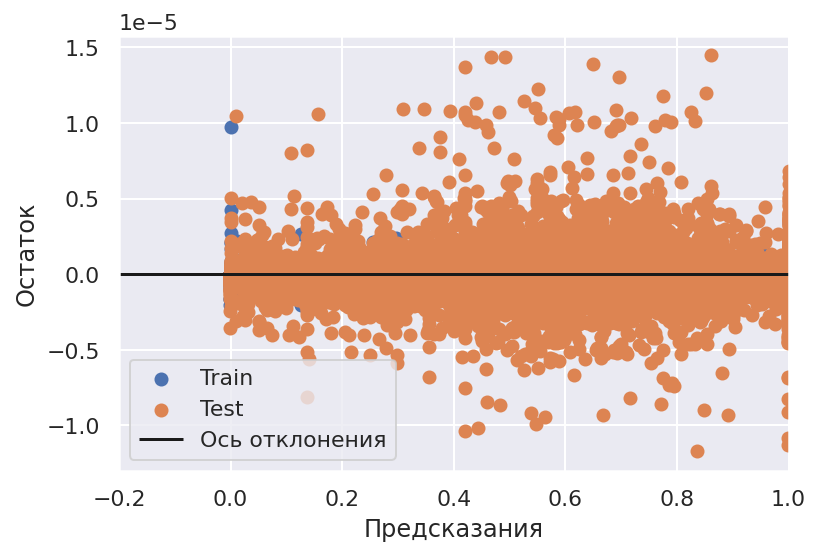

In [ ]:
graf(y_pred, y_test, y_train_pred, y_train)
plt.xlim([-0.2, 1])

In [ ]:
mean_absolute_error_test = mean_absolute_error(y_test, y_pred)
mean_absolute_error_train = mean_absolute_error(y_train, y_train_pred)

In [ ]:
print(f"Срееднее абсолютное отклонение для Линейной регрессии - Train: {mean_absolute_error_train}")
print(f"Срееднее абсолютное отклонение для Линейной регрессии - Test: {mean_absolute_error_test}")

Срееднее абсолютное отклонение для Линейной регрессии - Train: 4.538006245255504e-08
Срееднее абсолютное отклонение для Линейной регрессии - Test: 2.3745995876716265e-07


In [ ]:
print(inv_boxcox(mean_absolute_error_train, bc_lmbda))
print(inv_boxcox(mean_absolute_error_test, bc_lmbda))

1.0000000453800595
1.0000002374598775


In [ ]:
y_pred1 = gs_cv.best_estimator_.predict(X_test)
y_train_pred1 = gs_cv.best_estimator_.predict(X_train)

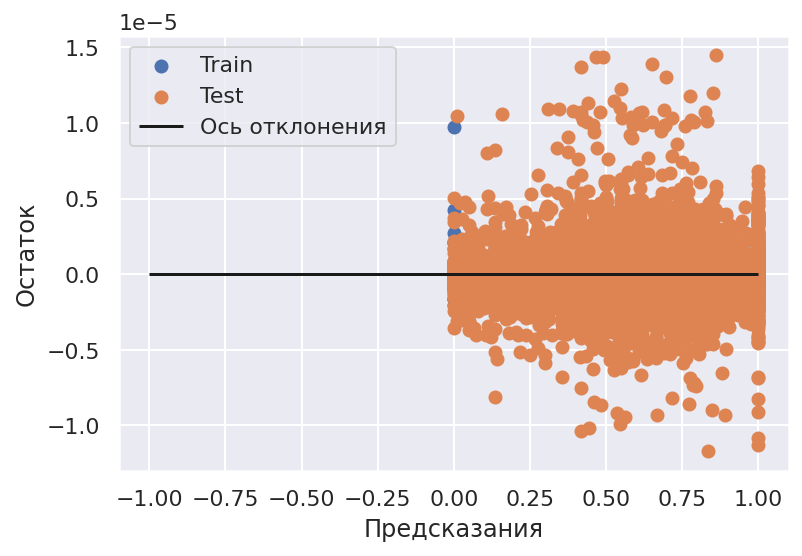

In [ ]:
graf(y_pred1, y_test, y_train_pred1, y_train)

Не отличается от прошлой диаграммы. Следовательно, дефолтная линейная регрессия на данный момент показывает лучший результат

In [ ]:
mae_test_pred = mean_absolute_error(y_test, y_pred1)
mae_train_pred = mean_absolute_error(y_train, y_train_pred1)

In [ ]:
print(f"Срееднее абсолютное отклонение для GridSearch - Train: {mae_train_pred}")
print(f"Срееднее абсолютное отклонение для GridSearch - Test: {mae_test_pred}")

Срееднее абсолютное отклонение для GridSearch - Train: 4.538006245255504e-08
Срееднее абсолютное отклонение для GridSearch - Test: 2.3745995876716265e-07


In [ ]:
print(inv_boxcox(mae_train_pred, bc_lmbda))
print(inv_boxcox(mae_test_pred, bc_lmbda))

1.0000000453800595
1.0000002374598775


Попробуем Lasso, Ridge, ElasticNet

In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print(inv_boxcox(lasso.score(X_train, y_train), bc_lmbda))

1.0


In [ ]:
y_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)

(-0.2, 1.0)

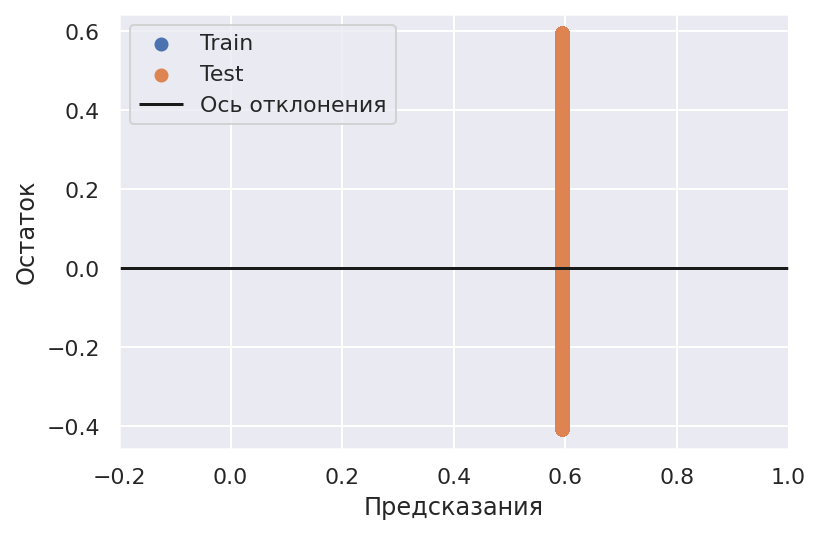

In [ ]:
graf(y_pred_lasso, y_test, y_train_pred_lasso, y_train)
plt.xlim([-0.2, 1])

Могу предположить, что Lasso обучилось предсказывать только одно значение.

In [ ]:
mae_test_lasso = mean_absolute_error(y_test, y_pred_lasso)
mae_train_lasso = mean_absolute_error(y_train, y_train_pred_lasso)

In [ ]:
print(f"Срееднее абсолютное отклонение для Lasso - Train: {mae_train_lasso}")
print(f"Срееднее абсолютное отклонение для Lasso - Test: {mae_test_lasso}")

Срееднее абсолютное отклонение для Lasso - Train: 0.1956964286267431
Срееднее абсолютное отклонение для Lasso - Test: 0.19566105635541003


In [ ]:
print(inv_boxcox(mae_train_lasso, bc_lmbda))
print(inv_boxcox(mae_test_lasso, bc_lmbda))

1.1567495093831814
1.1567262463941597


In [ ]:
en = ElasticNet(alpha=0.001, l1_ratio=0.5)
en.fit(X_train, y_train)
print(inv_boxcox(en.score(X_train, y_train), bc_lmbda))

1.126361085831625


In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
lasso_cv = LassoCV(cv=kfold, random_state=RANDOM_STATE, n_jobs=-1)
lasso_cv.fit(X_train[:500], y_train[:500])

LassoCV(alphas=None, copy_X=True,
        cv=KFold(n_splits=5, random_state=17, shuffle=False), eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=-1,
        normalize=False, positive=False, precompute='auto', random_state=17,
        selection='cyclic', tol=0.0001, verbose=False)

Так как модель считалась долго, пришлось обрезать данные

In [ ]:
lasso_cv.score(X_train, y_train)

0.9999989970017381

In [ ]:
print(inv_boxcox(lasso_cv.score(X_train, y_train), bc_lmbda))

1.504771967204032


(-0.2, 1.0)

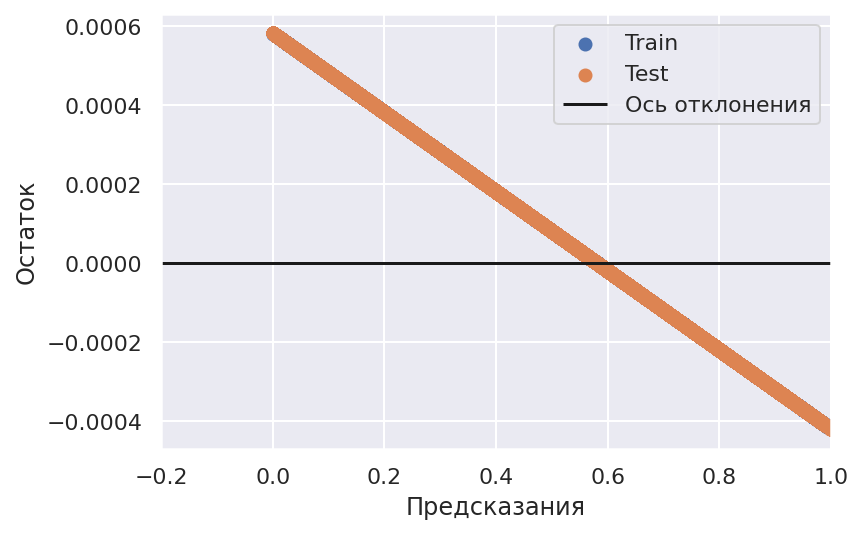

In [ ]:
graf(lasso_cv.predict(X_test), y_test, lasso_cv.predict(X_train), y_train)
plt.xlim([-0.2, 1])

**Вывод** сделать достаточно сложно. На первый взгляд модель имеет  небольшое отклонение от реальных показателей, но бывало лучше.

Попробуем подобрать гиперпараметр альфа для лассо

In [ ]:
gs_cv_lasso.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
print(inv_boxcox(gs_cv_lasso.best_score_, bc_lmbda))

1.2745199256563176


Т.к. результат не лучше других, то продолжать работать с lasso не буду

Решил попробовать стохастический грандиентный спуск.

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
sgd_reg = SGDRegressor(alpha=0.00001,
                       max_iter=500,
                       random_state=RANDOM_STATE)
sgd_reg.fit(X_train, y_train)
y_pred_sqd = sgd_reg.predict(X_test);

In [ ]:
sgd_reg.score(X_train, y_train)

0.9987195817231203

In [ ]:
print(inv_boxcox(sgd_reg.score(X_train, y_train), bc_lmbda))

1.5043771513497364


(-0.2, 1.0)

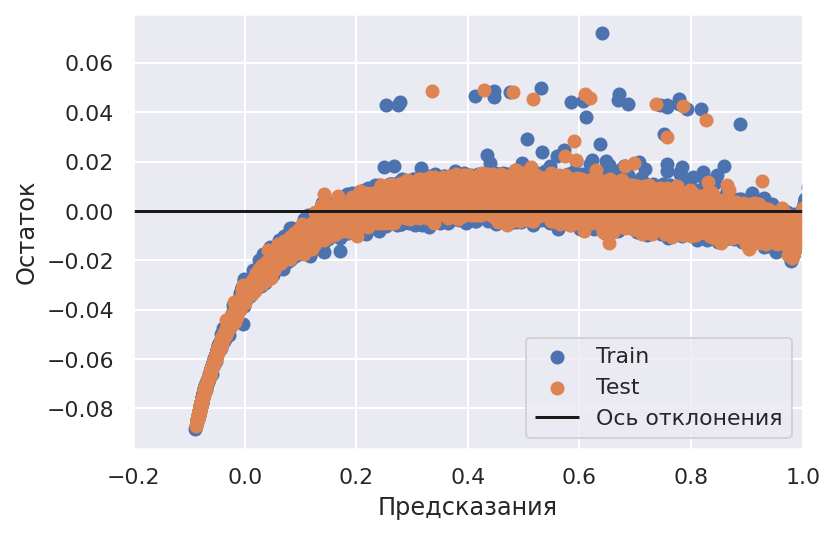

In [ ]:
graf(sgd_reg.predict(X_test), y_test, sgd_reg.predict(X_train), y_train)
plt.xlim([-0.2, 1])

**Вывод**: SGDRegressor - показывает не самый лучший результат относительно ошибки.

In [ ]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)
print(ridge.score(X_train, y_train))

0.9999991839888199


In [ ]:
print(inv_boxcox(ridge.score(X_train, y_train), bc_lmbda1))

1.504772024884749


(-0.2, 1.0)

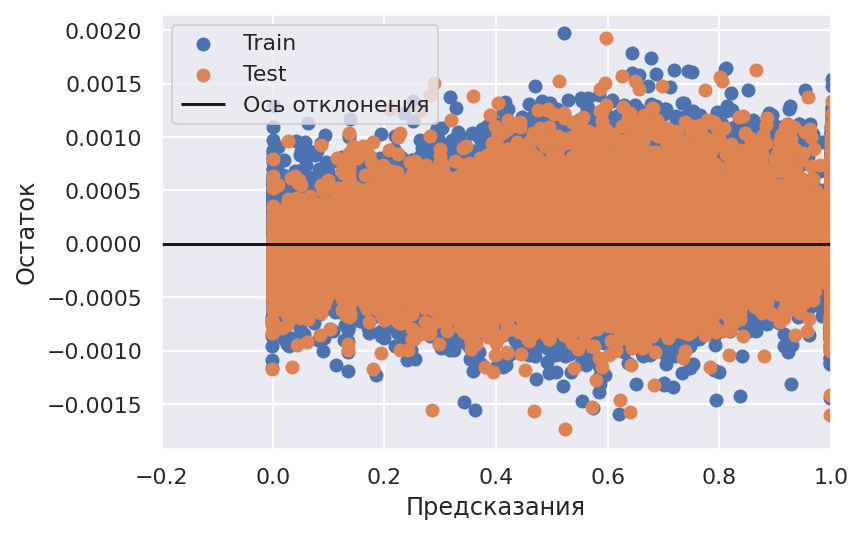

In [ ]:
graf(ridge.predict(X_test), y_test, ridge.predict(X_train), y_train)
plt.xlim([-0.2, 1])

In [ ]:
y_ridge_pred = ridge.predict(X_test)

In [ ]:
mae_test_ridge = mean_absolute_error(y_test, ridge.predict(X_test))
mae_train_ridge = mean_absolute_error(y_train, ridge.predict(X_train))

In [ ]:
print(f"Срееднее абсолютное отклонение для Ridge - Train: {mae_train_ridge}")
print(f"Срееднее абсолютное отклонение для Ridge - Test: {mae_test_ridge}")

Срееднее абсолютное отклонение для Ridge - Train: 0.00015451518800148898
Срееднее абсолютное отклонение для Ridge - Test: 0.00015409197623497318


In [ ]:
print(inv_boxcox(mae_train_ridge, bc_lmbda))
print(inv_boxcox(mae_test_ridge, bc_lmbda))

1.0001544808425447
1.00015405781863


**Вывод** Сначала показалось, но Ridge дал самое адекватное и маленькое отклонение от реального результата. Но.. присмотревшись, обычная линейная регрессия все еще лучше.

# Вывод

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
 X_train.shape

(161105, 300055)

In [ ]:
def graf_learning_curve(tree, name_tree):
  plt.figure()
  train_sizes, train_scores, test_scores = learning_curve(
      tree, X_train, y_train, scoring='neg_mean_absolute_error', n_jobs=-1)

  train_scores_mean = -1 * np.mean(train_scores, axis=1)
  train_scores_std = -1 * np.std(train_scores, axis=1)
  test_scores_mean = -1 * np.mean(test_scores, axis=1)
  test_scores_std =-1 * np.std(test_scores, axis=1)
  plt.grid()

  plt.title(name_tree)
  plt.xlabel("Объем данных")
  plt.ylabel("MAE")
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1,
                  color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Кривая обучения")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="Кривая валидации")

  plt.legend(loc="best")
  plt.show()

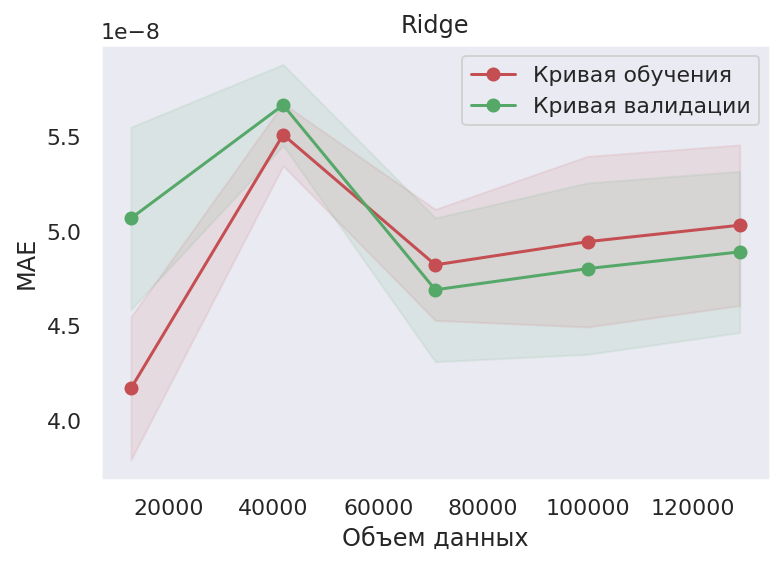

In [ ]:
graf_learning_curve(ridge, "Ridge")

**Итого**: так как две кривые располагаются близко и имеют низкую ошибку, то я думаю, что модель хорошо обучилась...

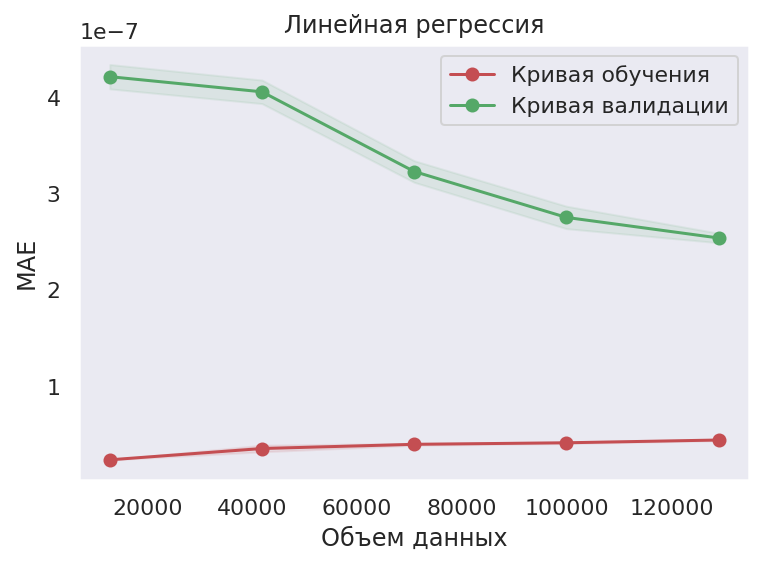

In [ ]:
graf_learning_curve(reg, "Линейная регрессия")

**Итого:** так как ошибка кривой валидации уменьшается по мере увеличения объема данных, есть предположение, что увеличение тренировочного набора может улучшить результат.

**Подводя итог по Ридж-регрессии и Линейной регрессии**, на текущий момент на 70% данных хорошо обучилась Ридж-регрессия, когда как для обычной линейной регрессии еще необходимо добавить новых данных, при том, что ее MAE имеет оценку гораздо лучше, чем у Ридж.

В результате удалось добиться лучшей точности **MAE**, относительно представленых решений в [Kernels](https://www.kaggle.com/gauthamp10/google-playstore-apps/kernels) 

---

У решений в разделе Kernels MAE в среднем 0,28. Но судя по решениям, датасет особо серьезно не решали.